In [532]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import datetime as dt
import intrinio
api_username = 'ea61edafb2b3aa7c2d50405626e4e455'
api_password = 'dfca7250d7d5f38fd57ff5f4061fee7f'
intrinio.client.password = api_password
intrinio.client.username = api_username
import pickle
import cufflinks as cf
cf.go_offline()
from jupyterthemes import jtplot
jtplot.style()
import arch 
import statsmodels.tsa.api as smt
from arch.univariate import EWMAVariance
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import statsmodels.api as sm
from functools import partial
import scipy 
from scipy import stats
import seaborn as sns
import pyfolio as pf
import pytz
from yahoo import YahooDailyReader
import re
sns.set_style('white')

In [6]:
import requests


requests.exceptions.TooManyRedirects

In [1070]:
def get_adj_close(tickers,start, end, source = 'yahoo'):
    panel = web.DataReader(tickers, source.lower(), start, end)
    if source == 'yahoo':
        table = panel['Adj Close']
    elif source == 'google':
        table = panel['Close']
    return table.sort_index(ascending = True)


# def drawdown(df_returns, ret_type = 'log'):
#     if ret_type == 'log':
#         cum_returns = np.exp(df_returns.cumsum())
    
#     elif ret_type == 'arth':
#         cum_returns = (1 + df_returns).cumprod()
#     draw = 1 - cum_returns.div(cum_returns.cummax())
#     max_drawdown = np.max(draw)
# #     print ("The maximum drawdown is:")
# #     print (max_drawdown.apply(lambda x: "{0:,.2%}".format(x)) )
#     return ("The maximum drawdown is: {0:,.2}%").format(max_drawdown)

def drawdown(df, data = 'returns', ret_type = 'arth'):
    if data == 'returns':
        if ret_type == 'arth':
            eq_line = (1 + df).cumprod()
        elif ret_type == 'log':
            eq_line = np.exp(df.cumsum())
    if data == 'prices':
        eq_line = df
        
    draw = 1 - eq_line.div(eq_line.cummax())
    max_drawdown = np.max(draw)
    return '{:,.2%}'.format(max_drawdown)
#     return ("The maximum drawdown is: {0:,.2}%").format(max_drawdown)

def rolling_drawdown(df, data = 'returns', ret_type = 'arth'):
    if data == 'returns':
        if ret_type == 'arth':
            eq_line = (1 + df).cumprod()
        elif ret_type == 'log':
            eq_line = np.exp(df.cumsum())
    if data == 'prices':
        eq_line = df
        
    draw = eq_line.div(eq_line.cummax()) - 1
#     max_drawdown = np.max(draw)
    return draw


def cum_pfmnce(dataframe, data = 'prices'):
    """Function that caluclates the cumulative performance of panel of prices. This is similar 
    to cumproduct of returns ie geometric returns
    
    Args: 
        dataframe: `DataFrame`
    Returns:
        `DataFrame` or `Panel` with cumulative performance
    """ 
    if data == 'prices':
        return dataframe.apply(lambda x: x/x[~x.isnull()][0])
    elif data == 'returns':
        line = dataframe.apply(lambda x: (1+x).cumprod())
        return line

In [711]:
def get_eq_line(series, data = 'returns', ret_type = 'arth', dtime = 'monthly'):
    if (isinstance(series, pd.core.series.Series)) and (isinstance(series.index, pd.DatetimeIndex)):
        pass
    else:
        raise NotImplementedError('Data Type not supported, should be time series')
        
    series.dropna(inplace = True)
    
    if data == 'returns':
        rets = series
        if ret_type == 'arth':
            cum_rets = (1+rets).cumprod()
        elif ret_type == 'log':
            cum_rets = np.exp(rets.cumsum()) 
        
        if dtime == 'daily':
            cum_rets_prd = cum_rets
            cum_rets_prd.iloc[0] = 1
            
        elif dtime == 'monthly':
            cum_rets_prd = cum_rets.resample('BM').last().ffill()
            cum_rets_prd.iloc[0] = 1
        elif dtime == 'weekly':
            cum_rets_prd = cum_rets.resample('W-Fri').last().ffill()
            cum_rets_prd.iloc[0] = 1
        
    elif data == 'prices':
        cum_rets = series/series[~series.isnull()][0]
        
        if dtime == 'daily':
            cum_rets_prd = cum_rets
        elif dtime == 'monthly':
            cum_rets_prd = cum_rets.resample('BM').last().ffill()
        elif dtime == 'weekly':
            cum_rets_prd = cum_rets.resample('W-Fri').last().ffill()
    
    
    
    
    return cum_rets_prd

In [ ]:
def get_exante_vol(series, com = 60, dtime = 'monthly'):
    if (isinstance(series, pd.core.series.Series)) and (isinstance(series.index, pd.DatetimeIndex)):
        pass
    else:
        raise NotImplementedError('Data Type not supported, should be only be timeseries')
    
    vol = series.ewm(com = com).std()
    ann_vol = vol * np.sqrt(261)
    
    if dtime == 'daily':
        ann_vol_prd = ann_vol
            
    elif dtime == 'monthly':
        ann_vol_prd = ann_vol.resample('BM').last().ffill()

    elif dtime == 'weekly':
        ann_vol_prd = ann_vol.resample('W-Fri').last().ffill()
        
        
    return ann_vol_prd

In [ ]:
def cnvert_daily_to(index, cnvrt_to = 'm'):
    cnvrt_to = cnvrt_to.lower()
    t_day_index = pd.DatetimeIndex(sorted(index))
    t_years = t_day_index.groupby(t_day_index.year)
    f_date = t_day_index[0]
    ann_dt = [f_date]
    qrter_dt = [f_date]
    mnthly_dt = [f_date]
    weekly_dt = [f_date]

    for yr in t_years.keys():
        yr_end = pd.DatetimeIndex(t_years[yr]).groupby(pd.DatetimeIndex(t_years[yr]).month)
        qrter_end = pd.DatetimeIndex(t_years[yr]).groupby(pd.DatetimeIndex(t_years[yr]).quarter)
        week_end = pd.DatetimeIndex(t_years[yr]).groupby(pd.DatetimeIndex(t_years[yr]).week)
        ann_dt.append(max(yr_end[max(yr_end)]))
        for q in qrter_end.keys():
            qrter_dt.append(max(qrter_end[q]))
        for m in yr_end.keys():
            mnthly_dt.append(max(yr_end[m]))
        for w, val in week_end.items():
            weekly_dt.append(max(val))
        
    
    if (cnvrt_to == 'monthly')| (cnvrt_to == 'm'):
        return mnthly_dt
    elif (cnvrt_to == 'quarterly')|(cnvrt_to == 'q'):
        return qrter_dt
    elif (cnvrt_to == 'annually')|(cnvrt_to == 'a'):
        return ann_dt
    elif (cnvrt_to == 'weekly')|(cnvrt_to == 'w'):
        return weekly_dt
    elif (cnvrt_to == 'daily')|(cnvrt_to == 'd'):
        return index
   

In [827]:
 
def get_ytd(table, year = 2017):
    this_year = dt.date.today().year
    grouped = table.index.groupby(table.index.year)
    #frst_day = min(grouped[this_year])
    index = grouped[this_year]
    pct = (table.loc[index].iloc[-1]/table.loc[grouped[year]].iloc[0]) - 1
#     return (pct.apply(lambda x: "{0:,.3f}".format(x*100)))
    return pct#.apply(lambda x: "{0:,.3f}".format(x))

def get_rets(data, kind = 'arth', freq = 'm', shift = 1):
    """Function to get returns from a Timeseries (NDFrame or Series) 
    
    params:
        data: `Dataframe` or `Series` daily EOD prices
        kind: (str) 'log'(default) or arth
        freq: (str) 'd' (default), 'w', 'm'
    
    returns:
        dataframe or Series"""
    if (isinstance(data, pd.core.series.Series)) or (isinstance(data, pd.core.frame.DataFrame)):
#         index_frq = cnvert_daily_to(data.index, cnvrt_to= freq)
#         data_prd = data.reindex(index_frq)
#         data_prd  = data_prd.sort_index()
        if freq == 'm':
            data_prd = data.resample('BM').last().ffill()
        elif freq == 'd':
            data_prd = data
        elif freq == 'w':
            data_prd = data.resample('W-Fri').last().ffill()
        
        if kind == 'log':
            returns = (np.log(data_prd/data_prd.shift(shift)))
        elif kind == 'arth':
            returns = data_prd.pct_change(periods = shift)
    elif (isinstance(data, np.ndarray)):
        raise KeyError('Data is not a time series. Pass data with index as datetime object')
        
    return returns       
  

In [836]:
def scaled_rets(data, freq = 'm'):
    rets = get_rets(data, kind='log', freq= freq)
    
    
    rf = rf.reindex(rets.index, fill = 'pad')
    cond_vol = rets.apply(lambda x: get_inst_vol(x, annualize= freq))
    scal_rets = rets/cond_vol.shift(-1)
    scal_rets.iloc[-1, :] = rets.mean()/rets.std()
    return scal_rets

def get_excess_rets(data, freq = 'd', kind = 'arth', shift = 1):
    rets = get_rets(data, kind = kind, freq = freq)
    start_date = rets.index[0]
    if freq == 'm':
        rets.index = rets.index.to_period(freq)
    
    if isinstance(rets, pd.core.frame.DataFrame):
        rets = rets.iloc[1:,:]
    elif isinstance(rets, pd.core.series.Series):
        rets = rets.iloc[1:]
    
    
    if freq == 'd':
        rf = (web.DataReader("F-F_Research_Data_Factors_daily", 
                             "famafrench", 
                             start= start_date)[0]['RF'])/100
    elif freq == 'w':
        rf =(web.DataReader("F-F_Research_Data_Factors_weekly", 
                            "famafrench", 
                            start= start_date)[0]['RF'])/100
    elif freq == 'm':
        rf = (web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start= start_date)[0]['RF'])/100
    rf = rf.reindex(rets.index, method = 'pad')    
    ex_rets = rets.sub(rf, axis = 0)
    return ex_rets

In [ ]:
# readfile
etf_table = pd.read_excel('ETFLists.xlsx', sheet_name= 'Consolidated', )

# remove etfs with NaN Avg Volume
etf_table = etf_table.loc[~etf_table['Avg Volume'].isnull(),: ]

# excel file was already sorted
sorter = 'Avg Volume'
# Number of ETFs you want to take into conisderation
n_etf = 100
top_etf_ticks = etf_table.iloc[:n_etf, 0].values

# The start and end date in consideration for analysis (currently 5 years)
yrs = 15
end_date = dt.datetime.today()
start_yr = (end_date - pd.DateOffset(years = yrs)).year
start_date = dt.datetime(start_yr, 1, 1)
# Get the adj closing price
# top_etf_panel = get_adj_close(top_etf_ticks, start_date, end_date, 'google')

In [14]:
# top_etf_panel = pd.DataFrame()
# for tick in top_etf_ticks:
#     ydr = YahooDailyReader(tick, start= start_date, end = end_date)
#     try:
#         df = ydr.read()
#         top_etf_panel[tick] = df['adjclose']
#     except requests.exceptions.TooManyRedirects:
#         pass

In [186]:
top_etf_panel.index = pd.DatetimeIndex(top_etf_panel.index)
top_etf_panel = top_etf_panel.sort_index(ascending= True)

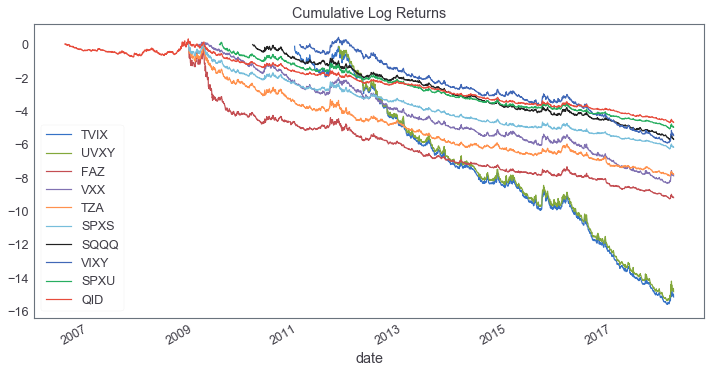

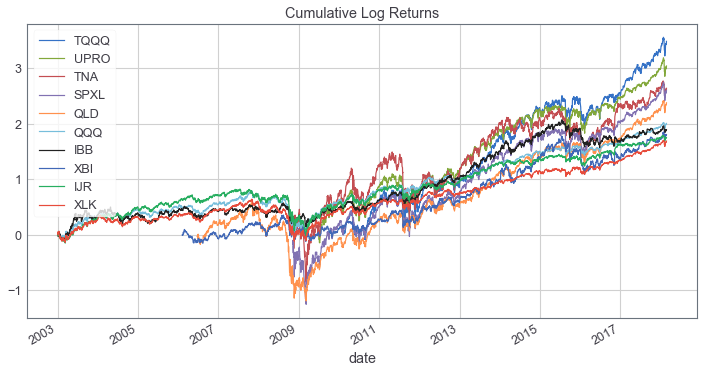

In [526]:
# Log rets and arithmatic rets
logrets = get_rets(top_etf_panel)
# arthrets = top_etf_panel.pct_change()

#check cumulative performance
pfmnce = cum_pfmnce(top_etf_panel)#top_etf_panel.apply(lambda x : x/x[~x.isnull()][0])
cumsum = logrets.cumsum()

# worst performers
sum_ = logrets.sum()

wrst_pf = list(sum_.nsmallest(10).index)
bst_pf = list(sum_.nlargest(10).index)
# Plot cumulative performances
cumsum[wrst_pf].plot(legend = True, title = 'Cumulative Log Returns', figsize= (12, 6), grid = False)
cumsum[bst_pf].plot(legend = True, title = 'Cumulative Log Returns', figsize= (12, 6))
# pfmnce.plot(legend = False, logy = True, title = 'Cumulative Returns, Log Scale', figsize= (10,5))

In [206]:
## 10 Largest Max Drawdowns
n = 20
drawdowns = drawdown(logrets)
n_large = (drawdowns.nlargest(n)).apply(lambda x : "{0:,.7}%".format(x * 100))
print(n_large.head())

TVIX    99.99998%
UVXY    99.99998%
FAZ     99.99263%
VXX     99.97886%
TZA     99.96857%
dtype: object


In [ ]:
# n_axes = []
# fig = plt.figure(figsize= (15, 10))
# nrows = 4
# ncols = 4
# layout = (nrows, ncols)
# for i in range(nrows):
#     for j in range(ncols):
#         n_axes.append(plt.subplot2grid(layout, (i,j)))

# for ticks in (top_etf_ticks[:10]):
#     smt.graphics.plot_acf(logrets[ticks].dropna(), 
#                           lags = 40, 
#                           title = 'Autocorrelation {}'.format(ticks), 
#                           zero = False
#                          )


In [66]:
def get_inst_vol(y, 
                 annualize,
                 x = None, 
                 mean = 'Constant', 
                 vol = 'Garch', 
                 dist = 'normal', 
                 ):

    """Fn: to calculate conditional volatility of an array using Garch:


    params
    --------------
    y : {numpy array, series, None}
        endogenous array of returns
    x : {numpy array, series, None}
        exogneous
    mean : str, optional
           Name of the mean model.  Currently supported options are: 'Constant',
           'Zero', 'ARX' and  'HARX'
    vol : str, optional
          model, currently supported, 'GARCH' (default),  'EGARCH', 'ARCH' and 'HARCH'
    dist : str, optional
           'normal' (default), 't', 'ged'

    returns
    ----------

    series of conditioanl volatility. 
    """
    if isinstance(y, pd.core.series.Series):
        ## remove nan.
        y = y.dropna()
    elif isinstance(y, np.ndarray):
        y = y[~np.isnan(y)]

    # provide a model
    model = arch.arch_model(y * 100, mean = 'constant', vol = 'Garch')

    # fit the model
    res = model.fit(update_freq= 5)

    # get the parameters. Here [1] means number of lags. This is only Garch(1,1)
    omega = res.params['omega']
    alpha = res.params['alpha[1]']
    beta = res.params['beta[1]']

    inst_vol = res.conditional_volatility * np.sqrt(252)
    if isinstance(inst_vol, pd.core.series.Series):
        inst_vol.name = y.name
    elif isinstance(inst_vol, np.ndarray):
        inst_vol = inst_vol
    
    # more interested in conditional vol
    if annualize.lower() == 'd':
        ann_cond_vol = res.conditional_volatility * np.sqrt(252)
    elif annualize.lower() == 'm':
        ann_cond_vol = res.conditional_volatility * np.sqrt(12)
    elif annualize.lower() == 'w':
        ann_cond_vol = res.conditional_volatility * np.sqrt(52)
    return ann_cond_vol * 0.01

# def scale_rets(y_,
#                x_ = None, 
#                mean_ = 'Constant', 
#                vol_ = 'Garch', 
#                dist_ = 'normal', 
#                convrt_to_ = 'm'):
    
#     cond_vol = get_inst_vol(y = y_, 
#                             x = x_, 
#                             vol = vol_, 
#                             dist = dist_, 
#                             annualize = convrt_to_ )
    
    

#### <center><b> Formula  for GARCH(1,1) </b></center>
$$r_t = \mu_t + \epsilon_t$$
$$\epsilon_t = \sigma_t e_t$$ 
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$
$$e_t\sim N(0,1)$$

<br>
<br>
<br>

Let's start by importing modules
```python
import arch
import pandas as pd
import numpy as np
```

<br>
<br>
<br>

_Define_ what the ``function`` is
<br>
<br>
<br>
<br>
```python
def get_inst_vol(y, 
                 x = None, 
                 mean = 'Constant', 
                 vol = 'Garch', 
                 dist = 'normal'):
    
    """Fn: to calculate conditional volatility of an array using Garch:
    
    
    params
    --------------
    y : {numpy array, series, None}
        endogenous array of returns
    x : {numpy array, series, None}
        exogneous
    mean : str, optional
           Name of the mean model.  Currently supported options are: 'Constant',
           'Zero', 'ARX' and  'HARX'
    vol : str, optional
          model, currently supported, 'GARCH' (default),  'EGARCH', 'ARCH' and 'HARCH'
    dist : str, optional
           'normal' (default), 't', 'ged'
           
    returns
    ----------
    
    series of conditioanl volatility. 
    """
    ```  

<br>    
<br>    
<br>    
<br> 
The above function will fit the GARCH(1,1) model to a time series and estimate the instantaneous volatility for the time series.


__params__:


1. **y:** is an array containing data to fit model on. It could either be `Series` or `Numpy Array`
2. **x:** in this case is the ecogenous variable, which is optional
3. **mean:** `str optional` Name of the model. Currently supported options are 'Constant', 'Zero', 'ARX' and 'HARX'
4. **vol:** `str optional` what model to use. 'GARCH' (default), 'EGARCH', 'ARCH' and 'HARCH'
5. **dist:** `str optional` 'normal'(default), 't', 'ged'


__returns__:

Time Series `pd.core.series.Series`

<br>
<br>
<br>
<br>
Let the code begin


``` python


    if isinstance(y, pd.core.series.Series):
        ## remove nan.
        y = y.dropna()
    elif isinstance(y, np.ndarray):
        y = y[~np.isnan(y)]
    
    # provide a model
    model = arch.arch_model(y * 100, mean = 'constant')
    
    # fit the model
    res = model.fit(update_freq= 5)
    
    # get the parameters. Here [1] means number of lags. This is only Garch(1,1)
    omega = res.params['omega']
    alpha = res.params['alpha[1]']
    beta = res.params['beta[1]']
    
    inst_vol = res.conditional_volatility * np.sqrt(252
    # instantaneous variance.
#     inst_var = (omega + 
#                 res.resid ** 2 * alpha + 
#                 res.conditional_volatility ** 2 * beta)
#     inst_vol = 0.01 * np.sqrt(inst_var)
    if isinstance(inst_vol, pd.core.series.Series):
        inst_vol.name = y.name
    elif isinstance(inst_vol, np.ndarray):
        inst_vol = inst_vol
    # more interested in conditional vol
    return inst_vol
    ```
<br>
<br>


- The first part of the code checks for the type of data we have entered. Is it in a series or a numpy array. Accordingly it then removes the null values. This is important as data with null value can't have a model fit to it.<br><br><br>
```python
model = arch.arch_model(y * 100, mean = 'constant')
res = model.fit(update_freq = 5)
```
- The second part provides information on what model to fit and does the same<br><br><br><br>

``` python
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']
```
- After fitting the model, we then estimate Garch(1,1) parameters i.e. $\alpha, \beta,\omega$ <br><br>

```python
inst_var = (omega + 
            res.resid ** 2 * alpha + 
            res.conditional_volatility ** 2 * beta)
inst_vol = 0.01 * np.sqrt(inst_var)
```

- Next we find instantaneous variance and then find the instantaneous volatility. We multiply with 0.01 because of our earlier mulitplication by 100 to our returns. <br><br>

$$ \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

In [752]:
((logrets.apply(lambda x: x.first_valid_index()))).to_csv('FirstETFTraded.csv')

In [67]:
# spy = top_etf_panel['SPY']
# spy_mnth = spy.reindex(cnvert_daily_to(spy.index, 'm'))

def get_lagged_params(y, param = 't', nlags = 24, name = None):
    if isinstance(y, pd.core.series.Series):
        y = y
    elif isinstance(y, np.ndarray):
        y = pd.Series(y)
    
    y.fillna(method = 'pad', inplace = True)
    y.dropna(inplace = True)
    if len(y) > nlags:
        t_stats = {}
        betas = {}
        for lag in range(1, nlags):
            reg = sm.OLS(y.iloc[lag:], y.shift(lag).dropna()).fit()
            t_stats[lag] = reg.tvalues[0]
        t_vals = pd.Series(t_stats)
        t_vals.name = name
    else:
        raise KeyError('Not enough datapoints for lags')
    return pd.Series(t_vals)

# def get_lagged_betas(y, nlags = 24)

def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))


In [68]:
# mnth_etf_panel = top_etf_panel.reindex(cnvert_daily_to(top_etf_panel.index, 'm'))
mnth_logrets = get_excess_rets(top_etf_panel, freq= 'm')#np.log(mnth_etf_panel.pct_change() + 1)
lagged_ts = pd.DataFrame([])
for col in mnth_logrets.columns:
    lagged_ts[col] = get_lagged_params(mnth_logrets[col], name = col, nlags= 24)


Text(0.5,1,'SPY Returns')

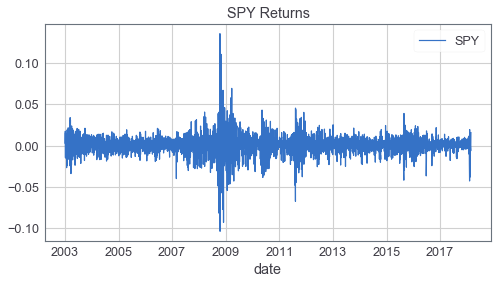

In [70]:
spy_rets = get_rets(top_etf_panel['SPY']).dropna()
spy_rets.plot(legend = True, figsize = (8, 4))
plt.title('SPY Returns')

In [71]:
# plt.plot(spy_rets.index.values, sigma2)
def init_squared_sigma(theta, x):
    omega = theta[0]
    alpha = theta[1]
    beta = theta[2]
    if isinstance(x, pd.core.series.Series):
        x = x.as_matrix()
    elif isinstance(x, np.ndarray):
        x = x
    
    n = len(x)
    x2 = x**2
    sigma2 = np.zeros(n)
    sigma2[0] = x2[0]
    
    for t in range(1, n):
        sigma2[t] = omega + (alpha * x2[t - 1]) + (beta * sigma2[t-1])
    return sigma2
# series = pd.Series(init_squared_sigma(spy_rets))
# series

In [72]:
def log_likelihood(theta, x):
    if isinstance(x, pd.core.series.Series):
        x = x.as_matrix()
    elif isinstance(x, np.ndarray):
        x = x
    n = len(x)
    sigma2 = init_squared_sigma(theta, x)
    log_likelihood = [-1/2 * (np.log(sigma2[t]) + ((x**2)[t]/sigma2[t])) for t in range(n)
                     ]
    sum_logs = -sum(log_likelihood)
    return sum_logs
# log_likelihood(x = spy_rets, theta = (0.0005, 0.1, 0.85))
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [315]:
opt = scipy.optimize.fmin(log_likelihood, 
                          x0 = np.array([0.0005, 0.1, 0.85]), 
                          args = (spy_rets * 100,),
                         )

Optimization terminated successfully.
         Current function value: 1416.327742
         Iterations: 130
         Function evaluations: 235


# Time Series Momentum Replication
#### This code replicates the Moskowitz paper on Time series momentum strategy with and without volatility scaling


In [1109]:
def tsmom(series, tolerance = 0, vol_flag = False, scale = 0.4):
    ast = series.name
    df = pd.concat([mnth_vol[ast], mnth_cum[ast], mnth_cum[ast].pct_change(12)], 
                      axis = 1, 
                      keys = ([ast + '_vol', ast + '_cum', ast + '_lookback']))
    cum_col = df[ast + '_cum']
    vol_col = df[ast + '_vol']
    lback = df[ast + '_lookback']

    pnl_dict = {}
    lev_dict = {}
    for k, v in enumerate(lback):
        if k <= 12:
            continue
        if vol_flag == True:
            leverage = (scale/vol_col[k-1])
            if lback.iloc[k-1] > tolerance:
                pnl_dict[lback.index[k]] = ((cum_col.iloc[k]/cum_col.iloc[k-1]) - 1) * leverage
                lev_dict[lback.index[k]] = leverage
            elif lback.iloc[k-1] < tolerance:
                pnl_dict[lback.index[k]] = ((cum_col.iloc[k-1]/cum_col.iloc[k]) - 1) * leverage
                lev_dict[lback.index[k]] = leverage
        elif vol_flag == False:
            leverage = 1
            if lback.iloc[k-1] > tolerance:
                pnl_dict[lback.index[k]] = ((cum_col.iloc[k]/cum_col.iloc[k-1]) - 1) 
                lev_dict[lback.index[k]] = leverage
            elif lback.iloc[k-1] < tolerance:
                pnl_dict[lback.index[k]] = ((cum_col.iloc[k-1]/cum_col.iloc[k]) - 1) 
                lev_dict[lback.index[k]] = leverage
    new_lev = pd.Series(lev_dict)
    new_series = pd.Series(pnl_dict)
    new_series.name = ast
    new_lev.name = ast + 'Leverage'
    return new_series, new_lev

In [773]:
def get_stats(returns, dtime = 'monthly'):
    if (isinstance(returns, pd.core.series.Series)) | (isinstance(returns, pd.core.frame.DataFrame)):
        mean = returns.mean()
        std = returns.std()
    else:
        try:
            mean = np.mean(returns)
            std = np.std(returns)
        except:
            raise TypeError
    if dtime == 'monthly':
        mean = mean * 12
        std = std * np.sqrt(12)
    elif dtime == 'daily':
        mean = mean * 252
        std = std * np.sqrt(252)
        
    sr = mean/std
    
    return (mean, std, sr)

def get_ts(df):
    df_ts = {}
    for i in df:
        df_ts[i] = ((get_lagged_params(df.loc[:, i], nlags = 48)))
    df_ts_df = (pd.DataFrame(df_ts))
    return df_ts_df

 <font size = 3> Get the relevant ``files`` from the local drive. Check the url for data. It provides in raw format. You can download and save it on your local drive <br> In this case the *book* is the ``DataFrame`` containing the returns of 54 continous Futures contract


In [447]:
url = 'https://github.com/quantopian/research_public/tree/master/advanced_sample_analyses/TSMOM/data'
factors = 'factors.csv'
futures = 'futures.csv'
fut_list = 'futures_list.csv'
book = pd.read_csv(futures, parse_dates= True, index_col= [0])
fut_info = pd.read_csv(fut_list)
# fut_info.head()

<font size = 3> Next we convert the returns to cumulative returns or equity lines and plot them. 

In [1031]:
daily_cum = book.apply(lambda x: get_eq_line(x, dtime = 'daily'))
mnth_cum = book.apply(lambda x: get_eq_line(x))
mnth_vol = book.apply(lambda x: get_exante_vol(x))
# daily_cum.plot(logy = True)

Text(0,0.5,'Cumulative Returns')

/Users/Ravi/anaconda/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning:

invalid value encountered in less_equal



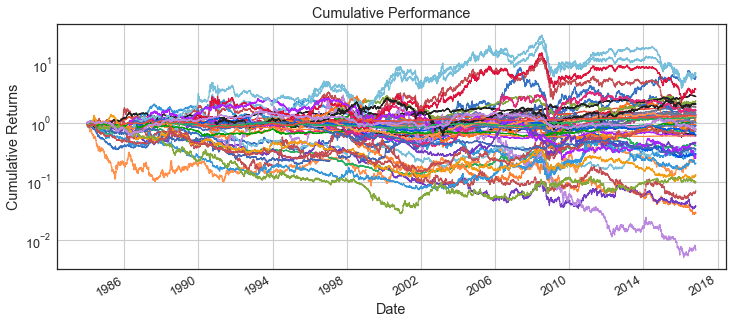

In [1036]:
daily_cum.plot(figsize = (12, 5), 
               logy = True,
               legend = False, 
               grid = True, 
               title = 'Cumulative Performance')
plt.ylabel('Cumulative Returns')

<font size=3> Next we find the excess returns to the continues futures contract. ``daily_cum`` get's converted to monthly and the code fetches the **Risk Free** rate from Fama-French Website

In [872]:
futures_exc_rets = get_excess_rets(daily_cum, kind = 'arth', freq = 'm')

In [994]:
tpose = futures_exc_rets.T
tpose.index.name = 'Asset'
tpose.reset_index(inplace = True)
merged = pd.merge(tpose, fut_info, on= 'Asset')
merged.sort_values(by = ['asset_class'.upper(), 'futures'.upper()], inplace = True)
merged.set_index(['asset_class'.upper(), 'futures'.upper()], inplace = True)
del merged['Asset']
straight = merged.T
bonds = (straight.BOND)
comm = (straight.COMMODITIES)
currncs = (straight.CURRENCIES)
eq_idx = (straight['EQUITY INDEXES'])

In [1018]:
df_ts_df = get_ts(comm)

/Users/Ravi/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Ravi/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2993: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for ALUMINIUM')

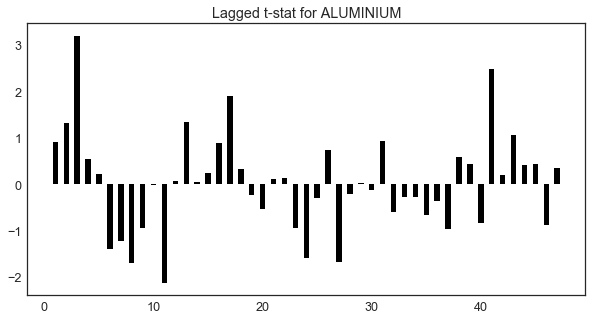

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for BRENT CRUDE')

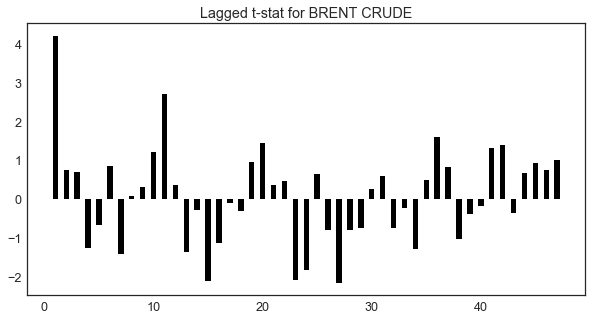

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for COCOA')

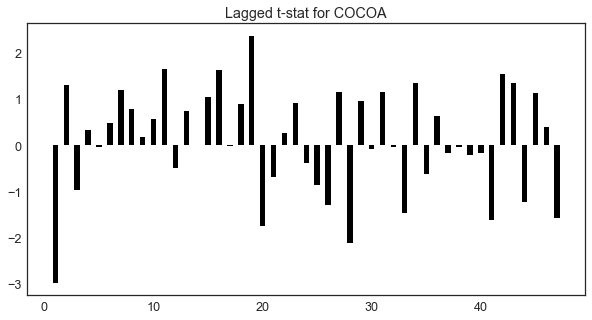

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for COFFEE')

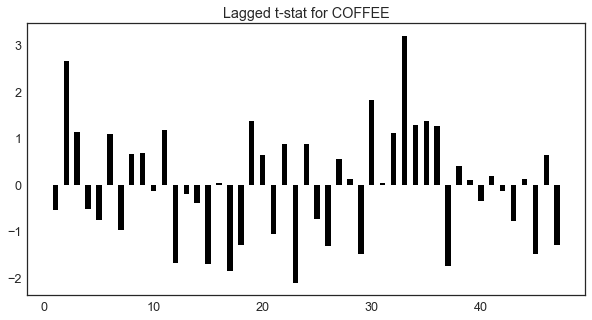

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for COPPER')

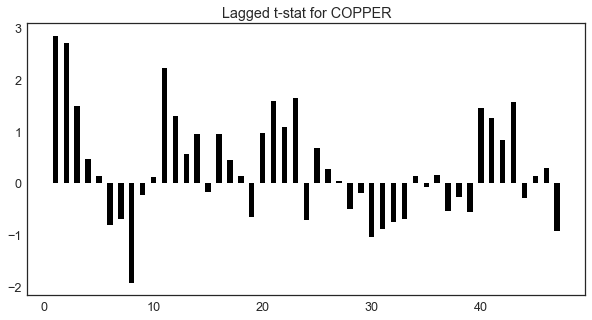

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for CORN')

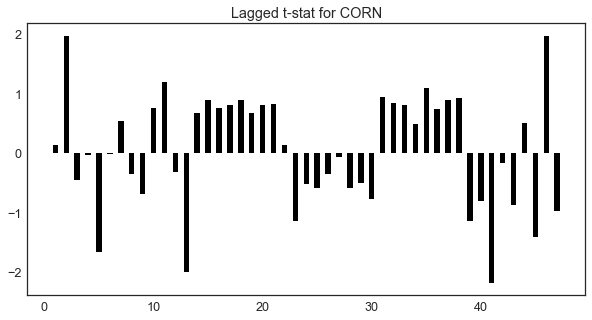

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for COTTON')

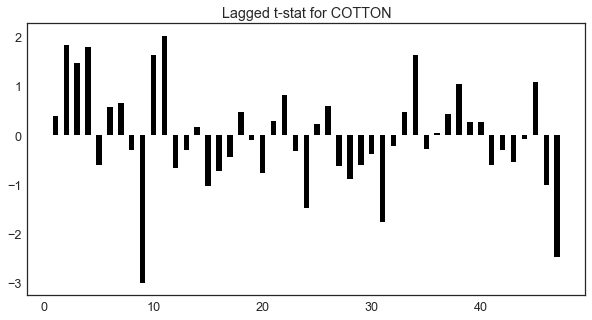

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for GASOIL')

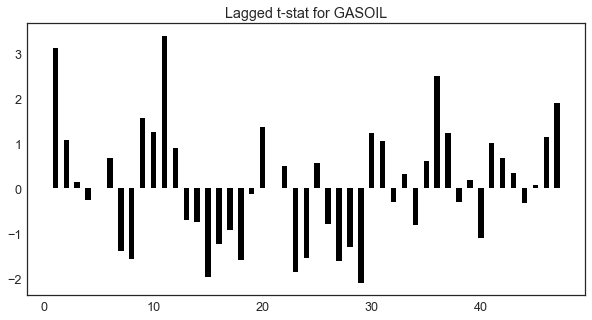

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for GOLD')

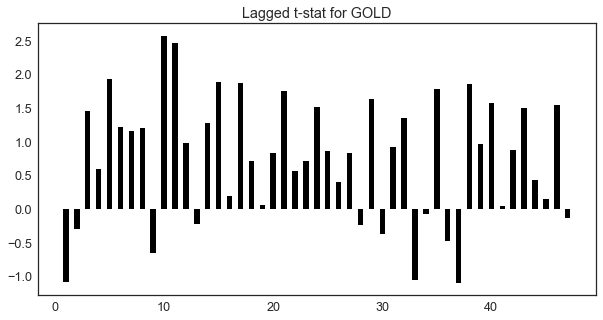

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for HEATING OIL')

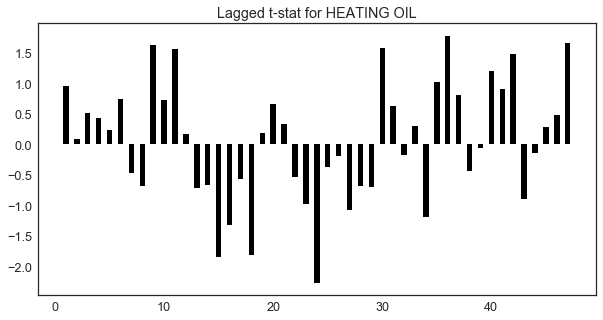

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for LEAN HOGS')

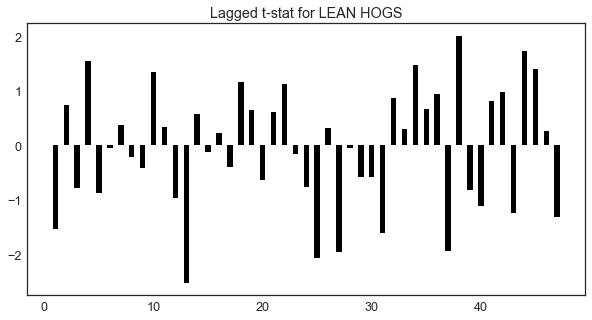

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for LIVE CATTLE')

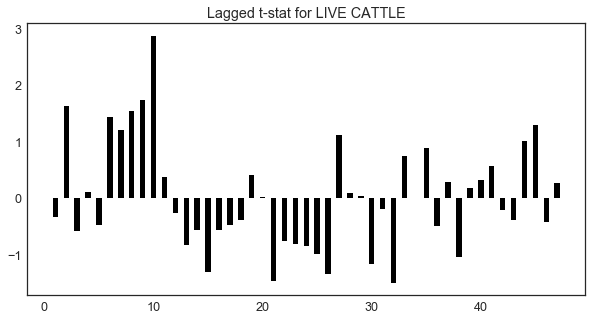

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for NATURAL GAS')

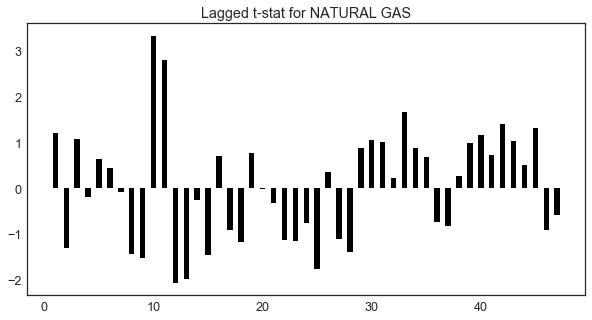

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for NICKEL')

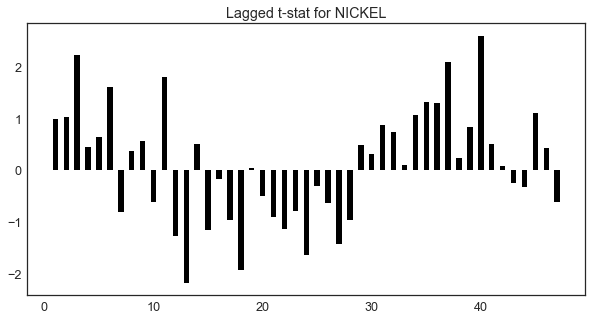

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for PLATINUM')

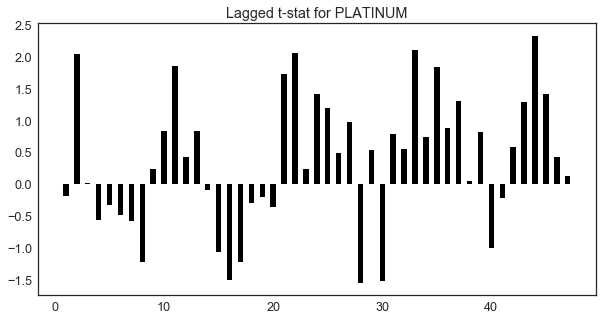

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for RBOB GASOLINE')

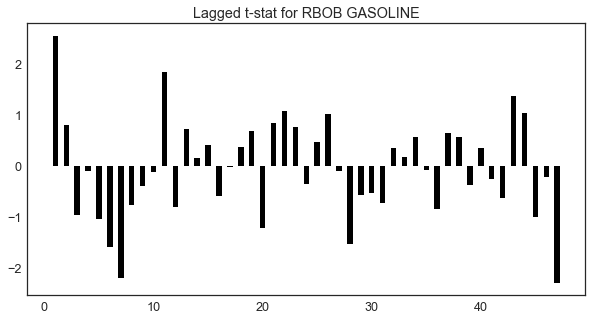

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for SILVER')

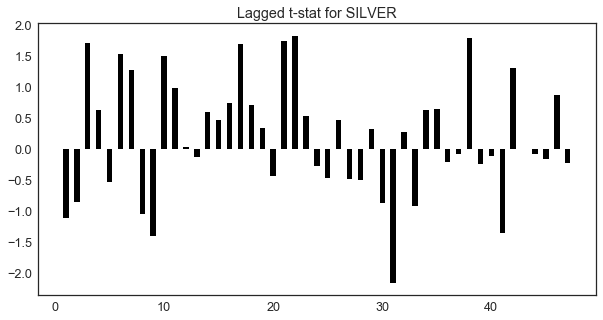

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for SOY MEAL')

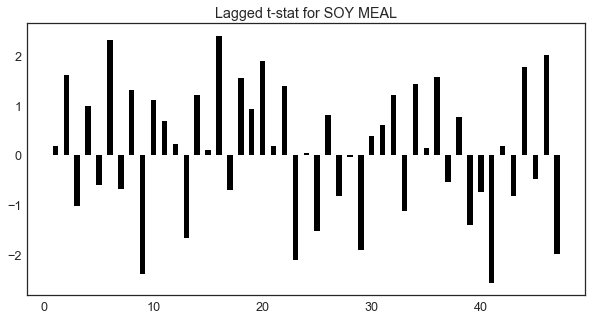

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for SOY OIL')

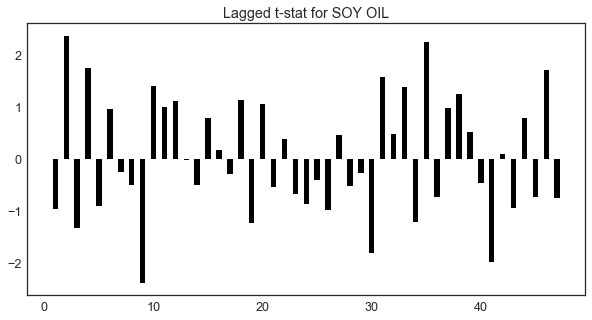

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for SOYBEANS')

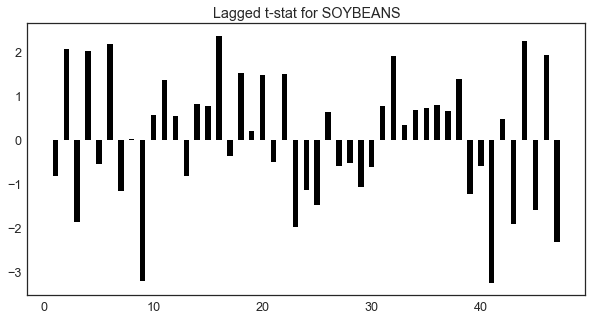

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for SUGAR')

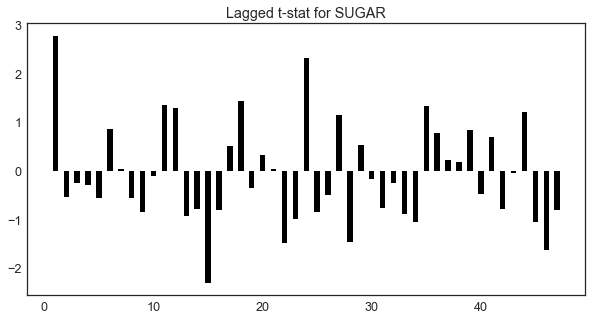

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for WHEAT')

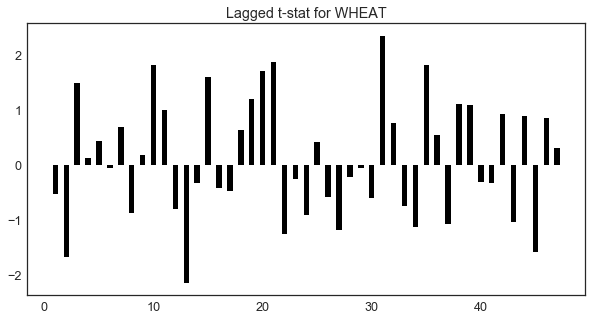

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for WTI CRUDE')

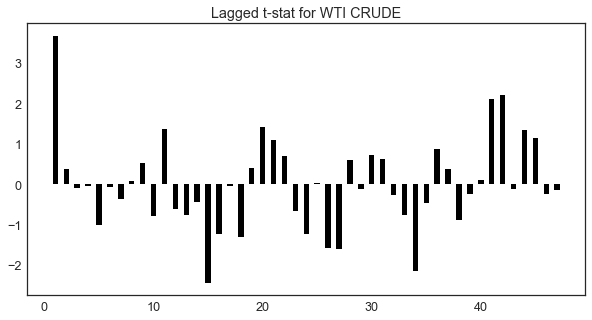

<Container object of 47 artists>

Text(0.5,1,'Lagged t-stat for ZINC')

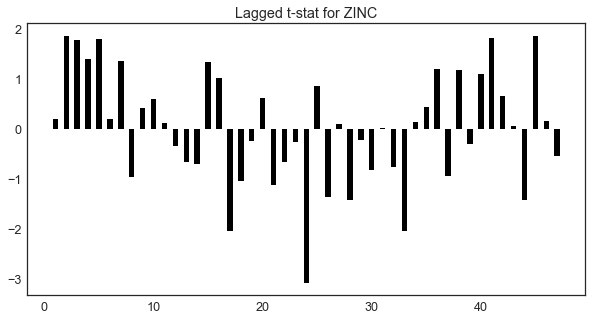

In [1021]:
for i in range(len(df_ts_df.columns)):
    ser = df_ts_df.iloc[:, i]
    # ser.plot(kind='bar', xticks=[10, 20, 30, 40, 50, 60])
    fig = plt.figure(figsize = (10, 5))
    plt.bar(ser.index, ser.values, width = 0.5, color = 'black')
    plt.title('Lagged t-stat for {}'.format(ser.name))
    plt.show()

In [1023]:
kurt = book.kurt()
kurt.name = 'Kurtosis'
ann_av = book.mean()*(252)
ann_av.name = 'Ann Mean'
ann_vol = book.std() * np.sqrt(252)
ann_vol.name = 'Ann Volatility'
sr_ = ann_av/ann_vol
sr_.name = 'Sharpe Ratio'
frst_dates = daily_cum.apply(lambda x: x.first_valid_index().strftime('%Y-%m-%d'))
frst_dates.name = 'Start'
sk = book.skew()
sk.name = 'Skewness'
sumstats = pd.concat([frst_dates, ann_av, ann_vol, sk, kurt, sr_], axis = 1)
sumstats.index.name = 'Asset'
sumstats.reset_index(inplace= True)
summerged = sumstats.merge(fut_info)

summerged.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
summerged.set_index(['asset_class'.upper(), 'futures'.upper()], inplace = True)
del summerged['Asset']
summerged.iloc[:, 1:] = summerged.iloc[:, 1:].applymap(lambda x: np.round(x, 3)) 

summerged.style.set_properties(**{'background-color' : 'black', 
                             'color': 'white', 
                             'text-align': 'center', 
                             'font-size': '10pt'})\
         .set_caption('Summary Statistics for Futures Contracts')\

In [74]:
stnd_df_idx = book.resample('BM').last().index
mnth_df = pd.DataFrame(index = stnd_df_idx)
mnth_vol_df = pd.DataFrame(index = stnd_df_idx)
sum_stats = pd.DataFrame(index =['Asset', 
                                 'Start', 
                                 'Ann Mean', 
                                 'Ann Volatility', 
                                 'Skewness', 
                                 'Kurtosis', 
                                 'Sharpe Ratio'
                                ]
                        )

In [75]:
for ast in book.columns:
    rets = book[ast]
    rets.dropna(inplace = True)
    first_date = rets.index[0].strftime('%Y-%m-%d')
    eq_line = (rets + 1).cumprod()
    eq_line.iloc[0] = 1
#     eq_line.plot(figsize = (8,5), legend = True)

    day_vol = rets.ewm(com = 60).std(bias = False)
    day_vol = day_vol * np.sqrt(261)
    
    eq_line = pd.concat([eq_line, day_vol], axis = 1)
    eq_line.columns = [ast, 'vol']
    
    eq_line_m = eq_line.resample('BM').last().ffill()
    
    eq_line_m[ast].iloc[0] = 1
    
    mnth_df = pd.concat([mnth_df, eq_line_m[ast]], axis= 1)
    
    tmp = eq_line_m[eq_line_m.columns[1]]
    tmp.name = ast + '_vol'
    
    mnth_vol_df = pd.concat([mnth_vol_df, tmp], axis= 1)
    
    _mean = eq_line[ast].pct_change().mean() * 252
    _std = eq_line[ast].pct_change().std() * np.sqrt(252)
    _skew = eq_line[ast].pct_change().skew()
    _kurt = eq_line[ast].pct_change().kurt()
    sr = _mean/_std
    
    stats = {'Asset': ast, 
             'Start': first_date, 
             'Ann Mean': _mean, 
             'Ann Volatility': _std, 
             'Skewness': _skew, 
             'Kurtosis': _kurt, 
             'Sharpe Ratio': sr}
    sum_stats[ast] = pd.Series(stats)

In [76]:
sum_statistics = sum_stats.T
all_ = sum_statistics.reset_index().merge(fut_info)
all_.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
all_.set_index(['Futures'.upper(), 'Asset_class'.upper()], inplace= True)
del all_['Asset'], all_['index']
all_.iloc[:, 1:] = all_.iloc[:, 1:].astype(float).round(decimals = 4)

In [616]:
# writer = pd.ExcelWriter('Summary Stats.xlsx')

# round(all_.iloc[0, 1:], 10)
all_.style.set_properties(**{'background-color' : 'black', 
                             'color': 'white', 
                             'text-align': 'center', 
                             'font-size': '10pt'})\
    .set_caption('Summary Statistics for Futures Contracts')\
#     .to_excel(writer, sheet_name = 'Stats')
# writer.close()

In [1126]:
def get_tsmom(flag = False, scale = 0.20):
    pnls = mnth_cum.apply(lambda x: tsmom(x, scale = scale, vol_flag= flag)[0])
    lev = mnth_cum.apply(lambda x: tsmom(x, scale = scale, vol_flag= flag)[1])
    port_pnl = pnls.mean(axis = 1)
    if flag == False:
        port_pnl.name = 'TSMOM'
    elif flag == True: 
        port_pnl.name = 'TSMOM VolScale'
    
#     strat_df = port_pnl.to_frame
    lev_mean = lev.mean(axis =1)
    lev_mean = lev_mean.rolling(12).mean()
    lev_mean.name = 'Leverage'
    
    return pd.concat([port_pnl, lev_mean], axis = 1)

In [1137]:
unlevered = get_tsmom()
levered = get_tsmom(flag = True, scale = 0.18)

In [1138]:
unlevered.loc[:, 'Cumulative'] = (1 + unlevered.loc[:, 'TSMOM']).cumprod()
levered.loc[:, 'Cumulative VolScale'] = (1 + levered.loc[:, 'TSMOM VolScale']).cumprod()

In [1088]:
spy_prices = pd.read_csv('spy_1985.csv', 
                         index_col = [0], 
                         parse_dates= True, 
                         dtype= {'Adj Close**': np.float64}, 
                         thousands = ',')
spy_prices = spy_prices.loc['1985-02-01':'2016-10-28', 'Adj Close**']

In [1092]:
spy_mnth_cum = get_eq_line(spy_prices, data = 'prices', dtime = 'monthly')
spy_rets = get_rets(spy_prices).dropna()
spy_rets_d = get_rets(spy_prices, freq= 'd')
spy_mean, spy_std, spy_sr = get_stats(spy_rets_d, dtime= 'daily')

print('Back test period is from {0} to {1} \
with a total of {2} days and {3} months \n\n'.format(spy_rets_d.index[0].date().strftime('%Y-%b'), 
                                                     spy_rets_d.index[-1].date().strftime('%Y-%b'), 
                                                     spy_rets_d.shape[0], 
                                                     spy_rets_d.resample('BM').last().shape[0]))
print(('Annualized Mean for SPY \
is: {0:,.3f}\nAnnualized volatility for SPY is: {1:,.3f}\n\
Sharpe Ratio for SPY is {2:,.3f}').format(spy_mean, spy_std, spy_sr))

Back test period is from 1985-Feb to 2016-Oct with a total of 8003 days and 381 months 


Annualized Mean for SPY is: 0.095
Annualized volatility for SPY is: 0.181
Sharpe Ratio for SPY is 0.522


In [1144]:
port_mean, port_std, port_sr = get_stats(levered.iloc[:, 0], 'monthly')

print('Back test period is from {0} to {1} \
with a total of {2} months \n\n'.format(port_pnl.index[0].date().strftime('%Y-%b'), 
                                        port_pnl.index[-1].date().strftime('%Y-%b'), 
                                        port_pnl.shape[0]))
print(('Annualized Mean for {0} \
is: {1:,.3f}\nAnnualized volatility for {0} is: {2:,.3f}\n\
Sharpe Ratio for {0} is {3:,.3f}').format(levered.iloc[:, 0].name, 
                                          port_mean, 
                                          port_std, 
                                          port_sr, 
                                           ))


Back test period is from 1985-Feb to 2016-Oct with a total of 381 months 


Annualized Mean for TSMOM VolScale is: 0.084
Annualized volatility for TSMOM VolScale is: 0.056
Sharpe Ratio for TSMOM VolScale is 1.478


In [1145]:
unlevered.loc[:, 'SPY'] = spy_mnth_cum
levered.loc[:, 'SPY'] = spy_mnth_cum

In [1146]:
import empyrical
# empyrical.alpha(port_pnl, spy_rets, period = 'monthly')

perf_att = pd.Series({'Annualized_Mean' : '{:,.2f}'.format(round(port_mean, 3)), 
                      'Annualized_Volatility': round(port_std, 3), 
                      'Sharpe Ratio' : round(port_sr, 3), 
                      'Calmar Ratio' : round(empyrical.calmar_ratio(levered.iloc[:,0], 
                                                                    period = 'monthly'), 
                                             3), 
                      'Alpha' : round(empyrical.alpha(levered.iloc[:,0], 
                                                      spy_rets, 
                                                      period = 'monthly'), 
                                      3), 
                      'Beta':  round(empyrical.beta(levered.iloc[:,0], 
                                                    spy_rets), 
                                     3), 
                      'Max Drawdown':  drawdown(levered.iloc[:,0]), 
                      'Sortino Ratio': round(empyrical.sortino_ratio(levered.iloc[:,0], 
                                                                     required_return= 0.03/12, 
                                                                     period = 'monthly'
                                                                    ), 
                                              3),
                     }, 
                    )
perf_att.name = port_pnl.name
perf_att.to_frame()

TSMOM
Alpha                  0.087
Annualized_Mean         0.08
Annualized_Volatility  0.056
Beta                  -0.037
Calmar Ratio           1.262
Max Drawdown           6.74%
Sharpe Ratio           1.478
Sortino Ratio          1.649

In [793]:
port_pnl_levered = port_pnl * spy_std/port_std
levered_cum = ((port_pnl_levered + 1).cumprod()) * 100
levered_cum.name = "Levered TSMOM vol as SPY's"

Text(0,0.5,'Cumulative Returns')

Text(0,0.5,'Rolling Leverage')

Text(0.5,0,'Date')

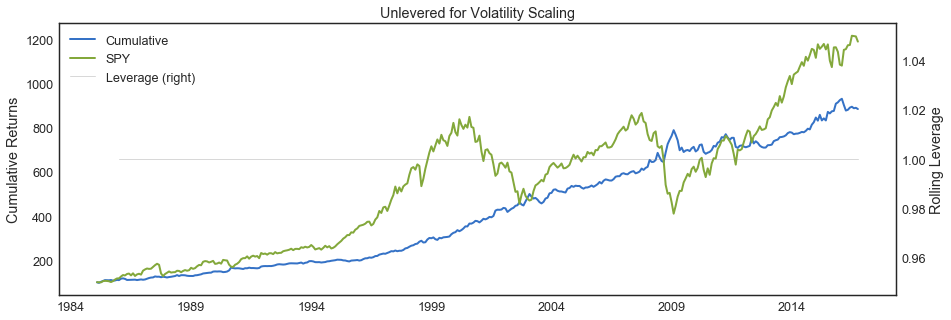

In [1150]:
# port_with_lev = pd.concat([(1+port_pnl).cumprod(), lev_mean, cum_spy_mnth], axis = 1)
(unlevered.iloc[:, -2:]*100).plot(legend = True, 
                               figsize = (15, 5), 
                               lw = 2, 
#                                color = 'Black', 
                               grid = False, 
                               title = 'Unlevered for Volatility Scaling')

plt.ylabel('Cumulative Returns')
unlevered.Leverage.plot(secondary_y= True, 
                            legend = True, 
                            grid = False,
                            lw = 1,
                            color = 'gray',
                            alpha = 0.3, 
                            )
plt.ylabel('Rolling Leverage')
plt.xlabel('Date')




In [1080]:

eastern = pytz.timezone('US/Eastern')
# spy_rets.index = spy_rets.index.tz_localize(pytz.utc).tz_convert(eastern)


Text(0,0.5,'Drawdown')

Text(0.5,1,'Daily Drawdown for TSMOM')

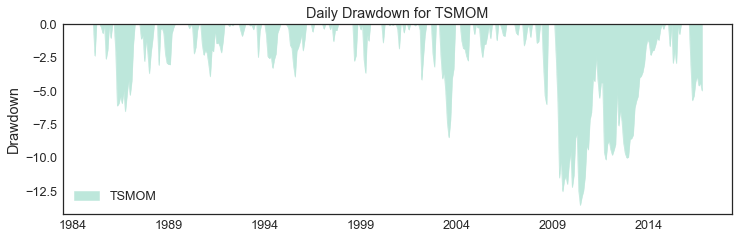

In [1069]:


eqspy = (1+port_pnl).cumprod()
dd = (eqspy/eqspy.cummax() - 1) * 100
dd = dd.apply(lambda x: np.round(x, 2))
ax = dd.plot(kind = 'area', 
              grid = False, 
              colormap = 'icefire', 
              figsize = (12,3.5), 
              legend = True, 
              lw = 0.5, 
#               lc = 5
              )
ax.set_ylabel('Drawdown')
ax.set_title('Daily Drawdown for {}'.format(dd.name))

pyfig =  dd.iplot(kind = 'area', 
                  fill = 'True', 
                  colors = 'red',
                  asFigure = True,
                  title = 'Underwater plot for {}'.format(dd.name),
                  layout_update = {'plot_bgcolor': 'white',
                                   'paper_bgcolor': 'white',
#                                    'hovermode': 'closest', 
                                   'margin': dict(t = 40, pad = -40), 
                                   'width': 800, 
                                   'height': 300, 
                                   'xaxis' : dict(title = 'Dates', 
                                                  showgrid = False, 
                                                  showticklabels = True, 
                                                  zeroline = True,
                                                  color = 'black',
                                                  hoverformat = '%A, %b %d %Y '
                                                 ), 
                                   'yaxis' : dict(title = 'Drawdown', 
                                                  showgrid = True, 
                                                  showticklabels = True, 
                                                  zeroline = True, 
                                                  color = 'black'
                                                 )
                                  }
                 )
iplot(pyfig, show_link = False)
# plt.title('Drawdowns')
# plt.xlim = ['2003-01-03', '2018-02-20']
# ax.margins(0.1, 0.1)



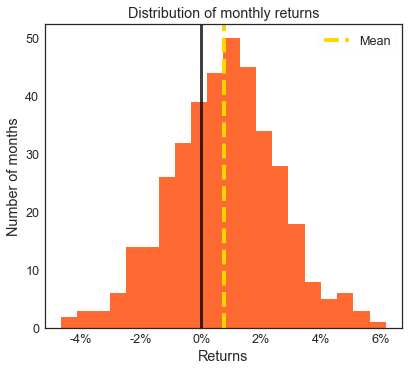

In [632]:
pf.plot_monthly_returns_dist(port_pnl)

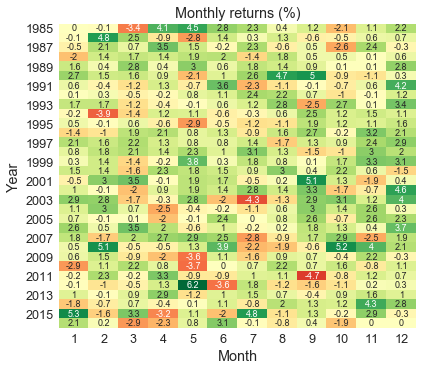

In [633]:
pf.plot_monthly_returns_heatmap(port_pnl, )

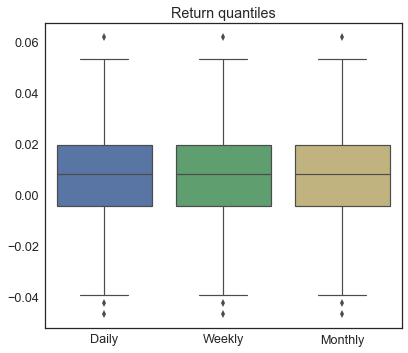

In [635]:
pf.plot_return_quantiles(port_pnl)

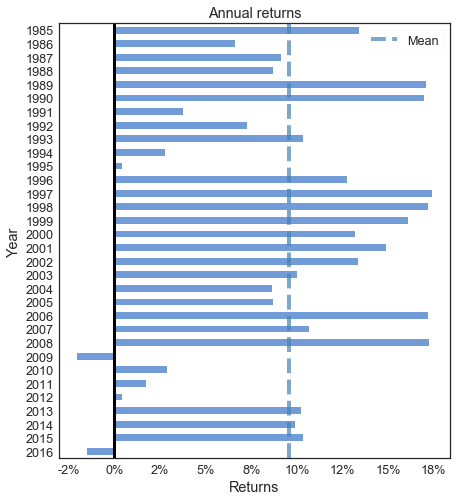

In [644]:
# figu = plt.Figure(figsize=(12, 6))
pf.plot_annual_returns(port_pnl, figsize = (7, 8))
